In [38]:
import numpy as np 
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Data Preparation
datapath = '140k_dataset/real-vs-fake/'
image_gen = ImageDataGenerator(rescale=1./255.)
batch_size = 64
train_flow = image_gen.flow_from_directory(
    datapath + 'train/', target_size=(224, 224), batch_size=batch_size, class_mode='binary'
)
valid_flow = image_gen.flow_from_directory(
    datapath + 'valid/', target_size=(224, 224), batch_size=batch_size, class_mode='binary'
)
test_flow = image_gen.flow_from_directory(
    datapath + 'test/', target_size=(224, 224), batch_size=1, shuffle=False, class_mode='binary'
)

Found 100000 images belonging to 2 classes.
Found 20003 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [10]:
def plot_img(path, set_):
    dir_ = os.path.join(path, 'train', set_)
    k = np.random.randint(20000)
    fig, ax = plt.subplots(3,3, figsize=(8,8))
    for j in range(3):
        for i in range(3):
            img = load_img(os.path.join(dir_, os.listdir(os.path.join(dir_))[k]))          
            ax[j,i].imshow(img)
            ax[j,i].set_title("")
            ax[j,i].axis('off')
            k = np.random.randint(20000)
    plt.suptitle(set_ + ' faces from train dataset')
    return plt

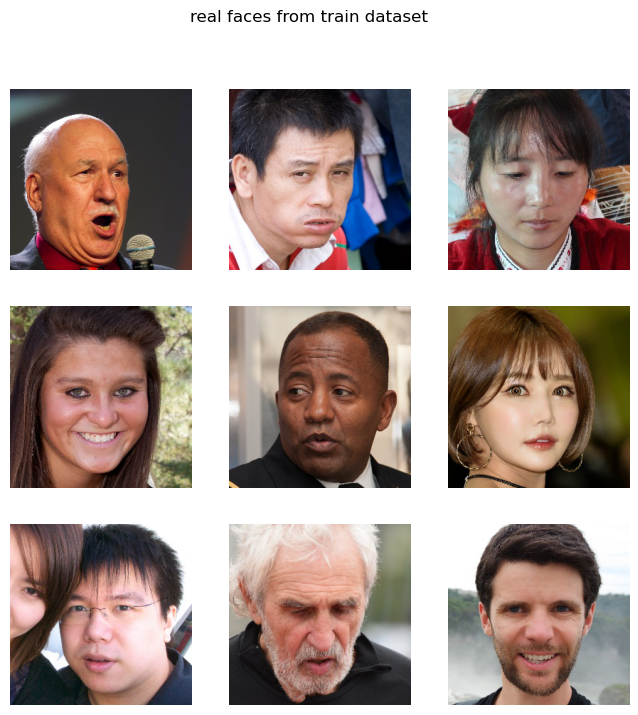

In [11]:
plot_img(datapath, 'real').show()

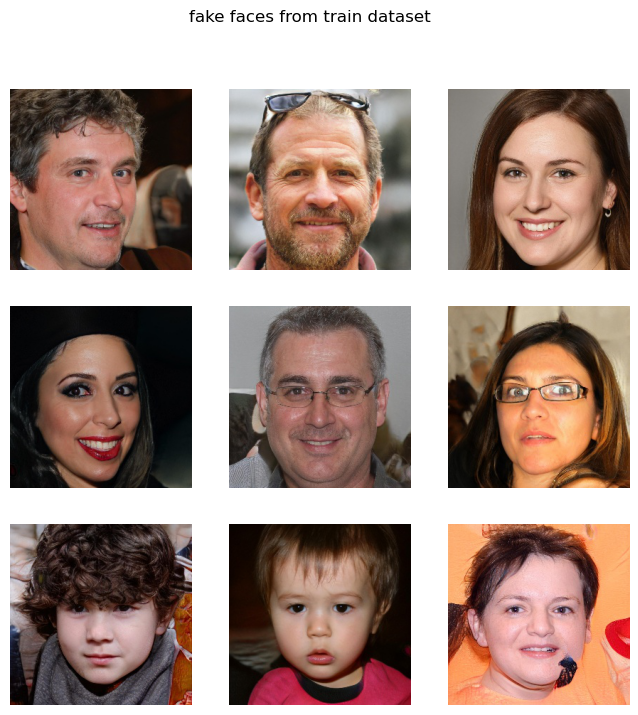

In [12]:
plot_img(datapath, 'fake').show()

In [14]:
# Base CNN Model
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(layers.BatchNormalization(input_shape=input_shape))
    model.add(layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(filters=1024, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [15]:
# Base EfficientNet Model
def create_efficientnet_model(input_shape):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [16]:
# Create CNN Model
cnn_model = create_cnn_model((224, 224, 3))
cnn_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])


/Users/prarthanarout/anaconda3/lib/python3.11/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-05-08 22:03:02.686223: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-05-08 22:03:02.686397: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-08 22:03:02.686416: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-08 22:03:02.686718: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-08 22:03:02.687268: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow devi

In [17]:
# Create EfficientNet Model
efficientnet_model = create_efficientnet_model((224, 224, 3))
efficientnet_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [20]:
# Train CNN Model
history=cnn_model.fit(
    train_flow,
    epochs=6,
    validation_data=valid_flow,
    callbacks=[ModelCheckpoint("saved-cnn-model.keras", monitor='val_accuracy', save_best_only=True, mode='max')],
)

Epoch 1/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1105s 706ms/step - accuracy: 0.7078 - loss: 0.6063 - val_accuracy: 0.7596 - val_loss: 0.5249
Epoch 2/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1204s 769ms/step - accuracy: 0.8435 - loss: 0.3533 - val_accuracy: 0.7597 - val_loss: 0.5874
Epoch 3/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1318s 842ms/step - accuracy: 0.8995 - loss: 0.2400 - val_accuracy: 0.8407 - val_loss: 0.4027
Epoch 4/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1139s 727ms/step - accuracy: 0.9316 - loss: 0.1704 - val_accuracy: 0.8687 - val_loss: 0.3490
Epoch 5/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1291s 825ms/step - accuracy: 0.9515 - loss: 0.1232 - val_accuracy: 0.9470 - val_loss: 0.1347
Epoch 6/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1728s 1s/step - accuracy: 0.9646 - loss: 0.0920 - val_accuracy: 0.9525 - val_loss: 0.1209


In [21]:
# # Train EfficientNet Model
# efficientnet_model.fit(
#     train_flow,
#     epochs=6,
#     validation_data=valid_flow,
#     callbacks=[ModelCheckpoint("saved-efficientnet-model.h5", monitor='val_accuracy', save_best_only=True, mode='max')],
# )

In [22]:
# Load Best Models
best_cnn_model = tf.keras.models.load_model("saved-cnn-model.keras")
#best_efficientnet_model = tf.keras.models.load_model("saved-efficientnet-model.keras")

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [53]:
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


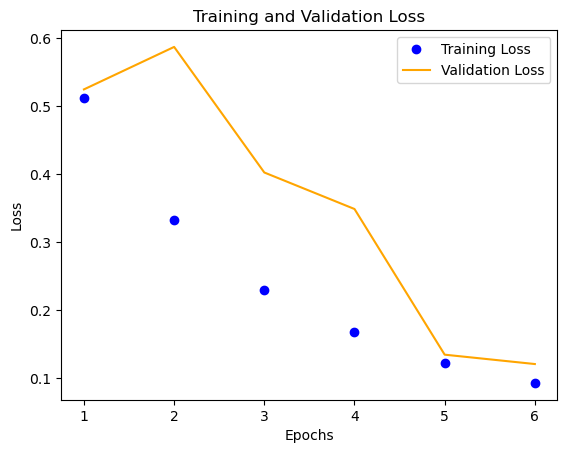

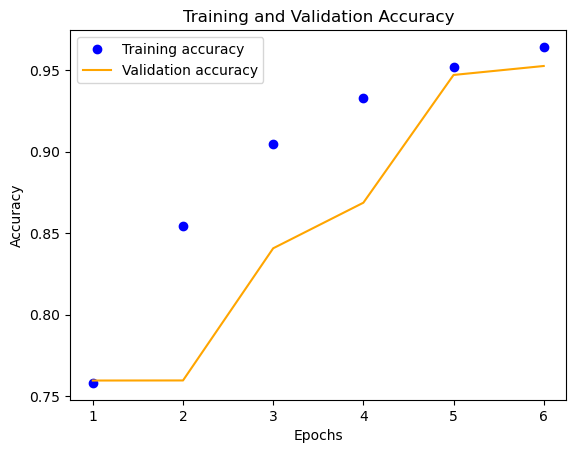

In [55]:
plot_loss(range(1, len(loss) + 1), loss, val_loss)
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

In [26]:
# Ensemble Learning
def ensemble_predict(models, test_data):
    predictions = [model.predict(test_data) for model in models]
    ensemble_preds = np.mean(predictions, axis=0)
    return ensemble_preds

In [27]:
# # Evaluate Ensemble Model
# ensemble_preds = ensemble_predict([best_cnn_model, best_efficientnet_model], test_flow)
# y_test = test_flow.classes
# ensemble_accuracy = accuracy_score(y_test, ensemble_preds > 0.5)
# print('Ensemble Model Accuracy:', ensemble_accuracy)

In [28]:
y_pred = cnn_model.predict(test_flow)
y_test = test_flow.classes

20000/20000 ━━━━━━━━━━━━━━━━━━━━ 154s 8ms/step


Accuracy Score : 0.95255
Report : 
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     10000
           1       0.99      0.92      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000



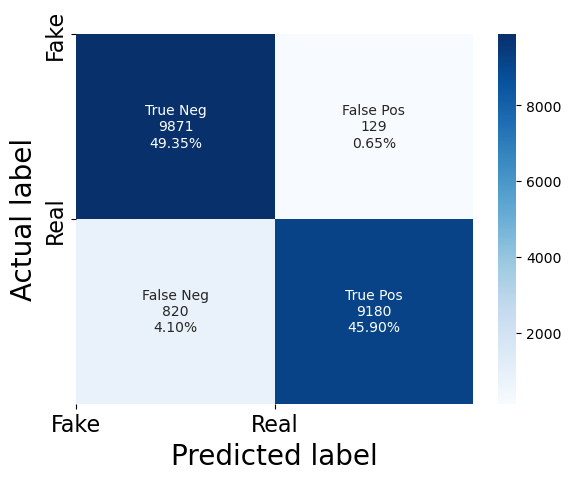

In [39]:
results = confusion_matrix(y_test, y_pred > 0.5) 
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in results.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in results.flatten()/np.sum(results)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(results, annot=labels, fmt='', cmap = 'Blues')
plt.ylabel('Actual label', size = 20)
plt.xlabel('Predicted label', size = 20)
plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
print('Accuracy Score :',accuracy_score(y_test, y_pred > 0.5))
print('Report : ')
print(classification_report(y_test, y_pred > 0.5))

In [42]:
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))

ROC-AUC Score: 0.99508597
AP Score: 0.994996404260461


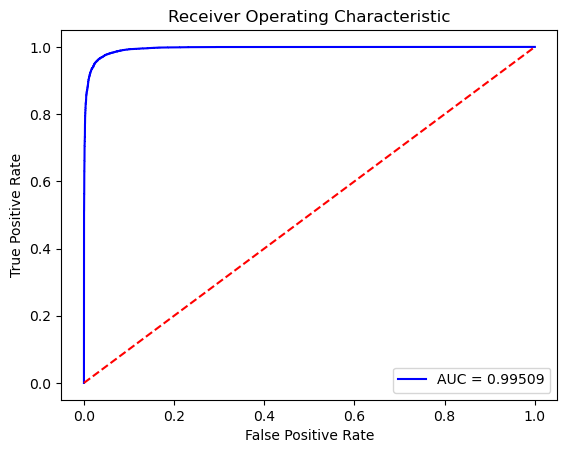

In [43]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Text(0.5, 1.0, 'Predicted by the model as REAL, actually is REAL')

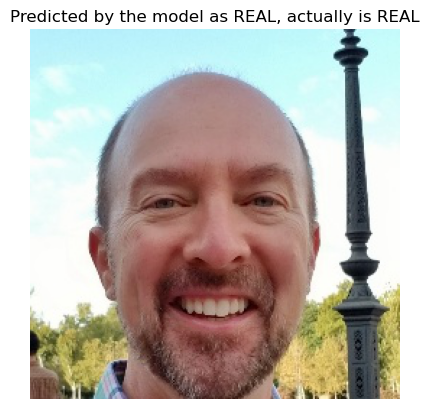

In [44]:
i = np.random.randint(20000)
datasetpath = test_flow.filenames[i]
imgpath = datapath+'test/'+datasetpath
plt.imshow(mpimg.imread(imgpath))
plt.axis('off')

if test_flow.classes[i] == 0:
    actual = "FAKE"
else:
    actual = "REAL"  
if cnn_model.predict(test_flow[i][0])[0][0]<0.5:
    prediction = "FAKE"
else:
    prediction = "REAL"

plt.title(f"Predicted by the model as {prediction}, actually is {actual}")

In [47]:
def predict_img_class():
    k = np.random.randint(20000)
    gridx = 4
    gridy = 4
    fig, ax = plt.subplots(gridx,gridy, figsize=(14,14))
    for j in range(gridx):
        for i in range(gridy):
            if test_flow.classes[k] == 0:
                actual = "FAKE"
            else:
                actual = "REAL"  
            if model.predict(test_flow[k][0])[0][0]<0.5:
                prediction = "FAKE"
            else:
                prediction = "REAL"
            datasetpath = test_flow.filenames[k]
            imgpath = datapath+'test/'+datasetpath
            img = load_img(imgpath)          
            ax[j,i].imshow(img)
            ax[j,i].set_title(f"Predicted: {prediction}, Actual: {actual}",size = 12)
            ax[j,i].axis('off')
            k = np.random.randint(20000)
    fig.suptitle('Testing the prediction on Test images', size = 20)
    return plt

1/1 [==============================] - 0s 18ms/step


<module 'matplotlib.pyplot' from '/Users/prarthanarout/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

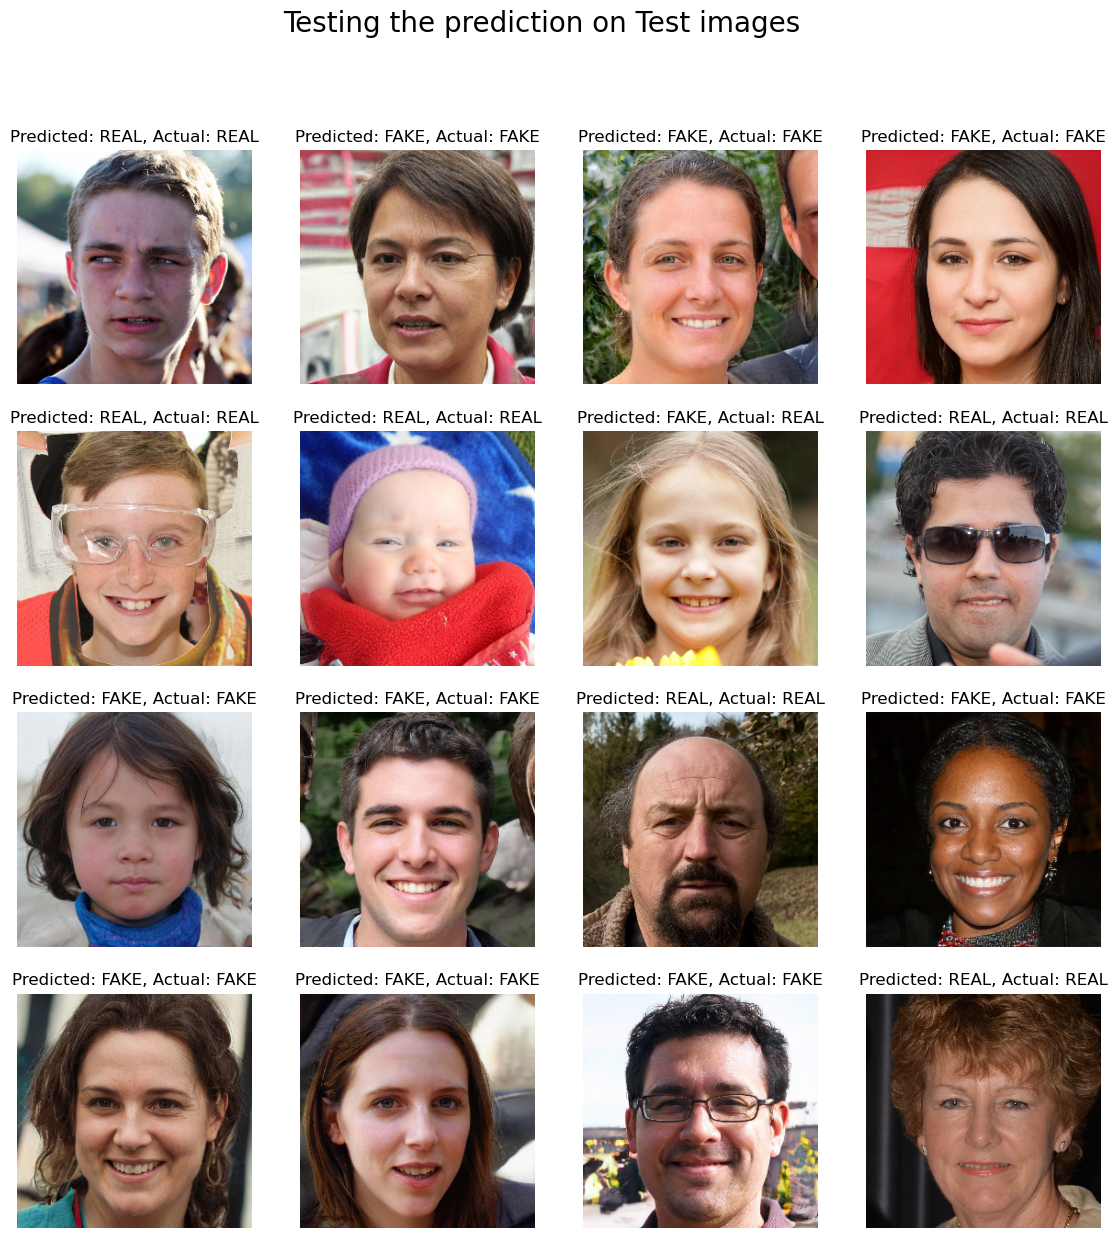

In [ ]:
predict_img_class()

In [48]:
# dataset link provided below
# https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces

In [51]:
import seaborn as sns
import matplotlib.image as mpimg
from sklearn import metrics
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [1]:
# Real-Time Prediction with Live Photo
live_photo_path = "/Users/prarthanarout/Detecting Deepfake images(StyleGAN)/140k_dataset/download (1).jpg"
live_photo = load_img(live_photo_path, target_size=(224, 224))
live_photo = img_to_array(live_photo) / 255.0
live_photo = np.expand_dims(live_photo, axis=0)

# Predict on Live Photo
live_prediction = best_cnn_model.predict(live_photo)

# Display Prediction Result
plt.imshow(mpimg.imread(live_photo_path))
plt.axis('off')
if live_prediction[0][0] < 0.5:
    prediction = "FAKE"
else:
    prediction = "REAL"
plt.title(f"Predicted as {prediction}")
plt.show()